In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import statsmodels.api as sm

from datetime import datetime
from datetime import timedelta
from scipy import optimize
from statsmodels.regression.linear_model import OLS
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models import SIRModel


# For figure aesthetics
plt.rcParams['mathtext.fontset'] = 'custom'  
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'  
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'  
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'  
plt.rcParams['font.size'] = 16
plt.rcParams['mathtext.fontset'] = 'stix'  
plt.rcParams['font.family'] = 'STIXGeneral' 

N = 211755692 # Brazil's population
date_fmt = '%Y-%m-%d'
gen_fcolor = False

In [2]:
def month2num(short_month):
    month_dict = {'Jan': 1, 'Fev': 2, 'Mar': 3, 'Abr': 4, 'Mai': 5, 'Jun': 6,
                  'Jul': 7, 'Ago': 8, 'Set': 9, 'Out': 10, 'Nov': 11, 'Dez': 12}
    month_num = month_dict[short_month]
    
    if month_num < 10:
        return '0' + str(month_num)
    else:
        return str(month_num)

In [3]:
df_br = pd.read_csv('./data/DadosBR.csv')
df_br['Date'] = pd.to_datetime(df_br["Updated"]).dt.strftime(date_fmt)
df_br.head(5)

,Unnamed: 0,ID,Updated,Confirmed,ConfirmedChange,Deaths,DeathsChange,Recovered,RecoveredChange,Latitude,Longitude,ISO2,ISO3,Country_Region,AdminRegion1,AdminRegion2,Date
0,38043,7159381,02/26/2020,1,NaN,0.0,NaN,NaN,NaN,-10.7768,-53.06805,BR,BRA,Brazil,NaN,NaN,2020-02-26
1,38044,340690,02/27/2020,1,0.0,0.0,0.0,NaN,NaN,-10.7768,-53.06805,BR,BRA,Brazil,NaN,NaN,2020-02-27
2,38045,340691,02/28/2020,1,0.0,0.0,0.0,NaN,NaN,-10.7768,-53.06805,BR,BRA,Brazil,NaN,NaN,2020-02-28
3,38046,7159385,02/29/2020,2,1.0,0.0,0.0,NaN,NaN,-10.7768,-53.06805,BR,BRA,Brazil,NaN,NaN,2020-02-29
4,38047,340693,03/01/2020,2,0.0,0.0,0.0,NaN,NaN,-10.7768,-53.06805,BR,BRA,Brazil,NaN,NaN,2020-03-01


In [4]:
ind0 = np.min(np.where(df_br['Deaths'] > 0.0))
day0 = df_br['Date'][ind0]
print(day0)

2020-03-17


In [5]:
df_br = df_br.iloc[ind0:]
df_br['Days Since First Death'] = [
    (datetime.strptime(d, date_fmt) - datetime.strptime(day0, date_fmt)
).days for d in df_br['Date']]

In [6]:
df_br.head(5)

,Unnamed: 0,ID,Updated,Confirmed,ConfirmedChange,Deaths,DeathsChange,Recovered,RecoveredChange,Latitude,Longitude,ISO2,ISO3,Country_Region,AdminRegion1,AdminRegion2,Date,Days Since First Death
20,38063,7159485,03/17/2020,291,57.0,1.0,1.0,2.0,0.0,-10.7768,-53.06805,BR,BRA,Brazil,NaN,NaN,2020-03-17,0
21,38064,7159491,03/18/2020,428,137.0,4.0,3.0,2.0,0.0,-10.7768,-53.06805,BR,BRA,Brazil,NaN,NaN,2020-03-18,1
22,38065,7159497,03/19/2020,621,193.0,7.0,3.0,2.0,0.0,-10.7768,-53.06805,BR,BRA,Brazil,NaN,NaN,2020-03-19,2
23,38066,7159502,03/20/2020,964,343.0,11.0,4.0,2.0,0.0,-10.7768,-53.06805,BR,BRA,Brazil,NaN,NaN,2020-03-20,3
24,38067,7159507,03/21/2020,1178,214.0,18.0,7.0,2.0,0.0,-10.7768,-53.06805,BR,BRA,Brazil,NaN,NaN,2020-03-21,4


In [7]:
df_br['ConfirmedChange_MA'] = df_br['ConfirmedChange'].rolling(window=7).mean()
df_br['DeathsChange_MA'] = df_br['DeathsChange'].rolling(window=7).mean()
df_br['RecoveredChange_MA'] = df_br['RecoveredChange'].rolling(window=7).mean()

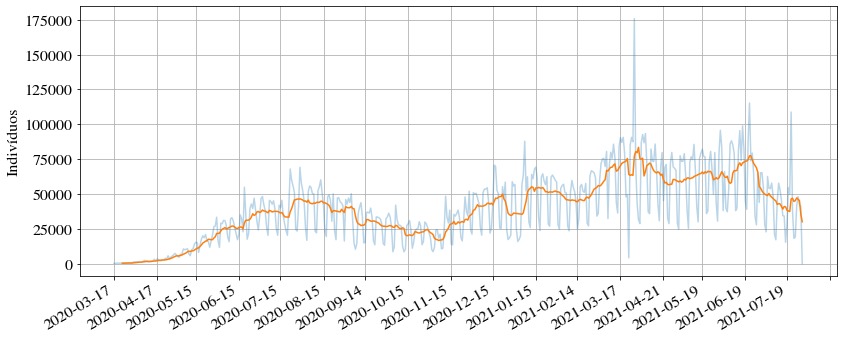

In [8]:
fig, ax = plt.subplots(figsize=(12, 5))
if gen_fcolor:
    fig.patch.set_facecolor((239 / 255, 239 / 255, 239 / 255))
    ax.set_facecolor((239 / 255, 239 / 255, 239 / 255))
ax.plot(df_br['Date'], df_br['ConfirmedChange'], alpha=0.3, label='Casos Reportados')
ax.plot(df_br['Date'], df_br['ConfirmedChange_MA'], label='Média Móvel de Casos')
#ax.plot(df_leitos['Data'], df_leitos['Total'], label='Leitos Disponíveis')
ax.set_ylabel('Indivíduos')

#xfmt = mdates.DateFormatter('%b/')
months = mdates.MonthLocator()
ax.xaxis.set_major_locator(months)

#ax.xaxis.set_major_formatter(xfmt)
plt.grid()
fig.autofmt_xdate()
plt.tight_layout()

In [9]:
time_span = df_br['Days Since First Death'].values.copy()
time_span_str = df_br['Date'].values.copy()
real_y = df_br['ConfirmedChange_MA'].values.copy()
ind_max = np.max(np.where(pd.isnull(real_y))[0])

time_span = time_span[ind_max + 1:200]
time_span_str = time_span_str[ind_max + 1:200]
real_y = real_y[ind_max + 1:200]

In [10]:
def obj_fn(x, t=time_span, real_y=real_y):
    beta, gamma, I0 = x[0], x[1], x[2]
    S0 = 1 - I0
    initial_conditions = [S0, I0, 0.0]
    model = SIRModel(β=beta, γ=gamma, N=1.0)
    solution = model(time_span, initial_conditions)
    y = solution[:, 1]
    
    return np.mean((y * N - real_y) ** 2)

In [11]:
result = optimize.differential_evolution(obj_fn,
                                         bounds=[(1, 10), (1, 5), (1e-8, 1e-5)],
                                         popsize=15)

In [12]:
beta, gamma, I0 = result.x
S0 = 1 - I0
print(beta, gamma, I0, beta / gamma)

initial_conditions = [S0, I0, 0.0]
model = SIRModel(β=beta, γ=gamma, N=1.0)
solution = model(time_span, initial_conditions)
y = solution[:, 1]

1.5962297314390745 1.564114578536036 1e-05 1.020532481023927


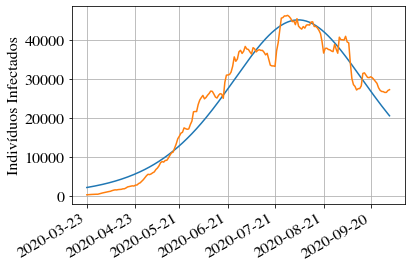

In [13]:
fig, ax = plt.subplots()
if gen_fcolor:
    fig.patch.set_facecolor((239 / 255, 239 / 255, 239 / 255))
    ax.set_facecolor((239 / 255, 239 / 255, 239 / 255))
ax.plot(time_span_str, y * N)
ax.plot(time_span_str, real_y)
ax.set_ylabel('Indivíduos Infectados')
#xfmt = mdates.DateFormatter('%b/')
months = mdates.MonthLocator()
ax.xaxis.set_major_locator(months)

#ax.xaxis.set_major_formatter(xfmt)
plt.grid()
fig.autofmt_xdate()
plt.tight_layout()



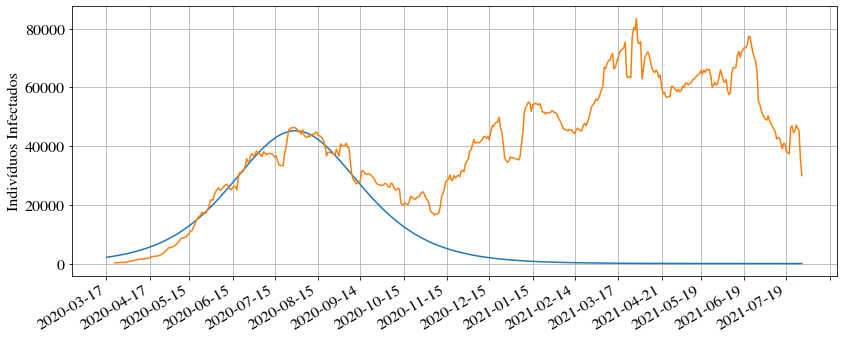

In [14]:
time_span = df_br['Days Since First Death'].values.copy()
real_y = df_br['ConfirmedChange_MA'].values.copy()

initial_conditions = [S0, I0, 0.0]
model = SIRModel(β=beta, γ=gamma, N=1.0)
solution = model(time_span, initial_conditions)
y = solution[:, 1]

fig, ax = plt.subplots(figsize=(12, 5))
if gen_fcolor:
    fig.patch.set_facecolor((239 / 255, 239 / 255, 239 / 255))
    ax.set_facecolor((239 / 255, 239 / 255, 239 / 255))
ax.plot(df_br['Date'], y * N)
ax.plot(df_br['Date'], real_y)
ax.set_ylabel('Indivíduos Infectados')

#xfmt = mdates.DateFormatter('%b/')
months = mdates.MonthLocator()
ax.xaxis.set_major_locator(months)

#ax.xaxis.set_major_formatter(xfmt)
plt.grid()
fig.autofmt_xdate()
plt.tight_layout()

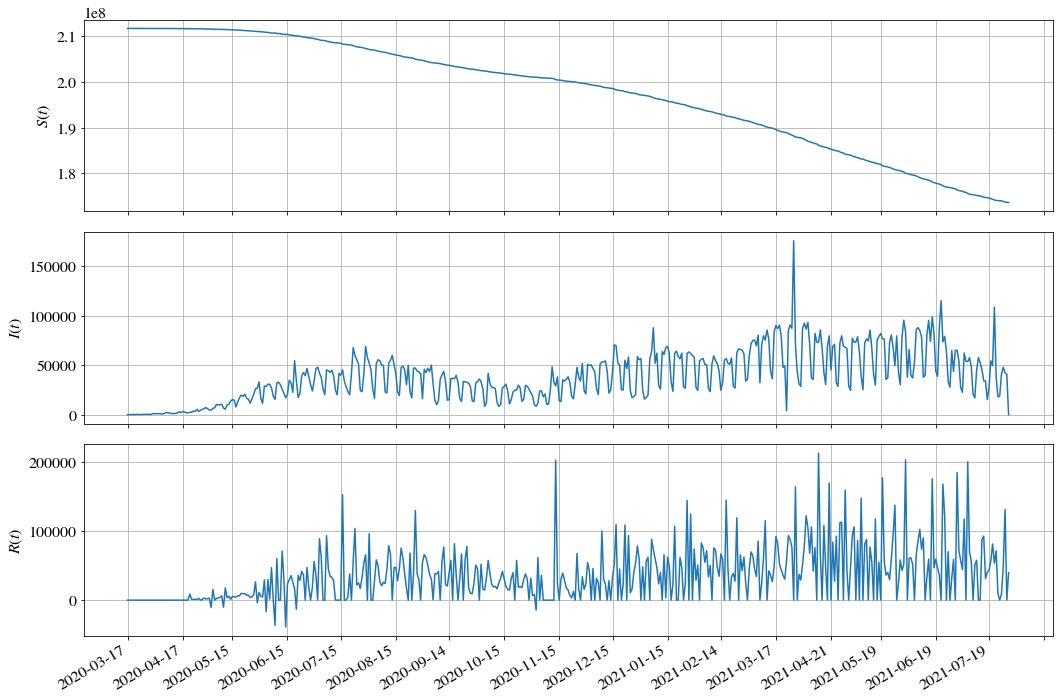

In [16]:
time_span = df_br['Days Since First Death'].values.copy()
new_cases = df_br['ConfirmedChange'].values.copy()
new_cases[pd.isnull(new_cases)] = 0
new_deaths = df_br['DeathsChange'].values.copy()
new_deaths[pd.isnull(new_deaths)] = 0
new_recovered = df_br['RecoveredChange'].values.copy()
new_recovered[pd.isnull(new_recovered)] = 0
S = N - np.cumsum(new_cases) - np.cumsum(new_deaths) - np.cumsum(new_recovered)

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
if gen_fcolor:
    fig.patch.set_facecolor((239 / 255, 239 / 255, 239 / 255))
    for ax in axes: ax.set_facecolor((239 / 255, 239 / 255, 239 / 255))
ax = axes[0]
ax.plot(df_br['Date'], S)
ax.set_ylabel("$S(t)$")
ax = axes[1]
ax.plot(df_br['Date'], new_cases)
ax.set_ylabel("$I(t)$")
ax = axes[2]
ax.plot(df_br['Date'], new_recovered)
ax.set_ylabel("$R(t)$")

#xfmt = mdates.DateFormatter('%b/')
months = mdates.MonthLocator()
ax.xaxis.set_major_locator(months)

#ax.xaxis.set_major_formatter(xfmt)
for ax in axes: ax.grid()
fig.autofmt_xdate()
plt.tight_layout()

In [17]:
accumulated_values = np.zeros([7,])
for t, yt in zip(df_br['Updated'].values.copy(), df_br['ConfirmedChange'].values.copy()):
    date = datetime.strptime(t, "%m/%d/%Y")
    accumulated_values[date.weekday()] += yt

Text(0, 0.5, '% de Casos Reportados')

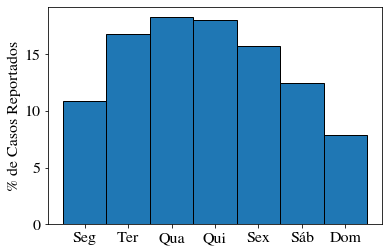

In [18]:
fig, ax = plt.subplots(1, 1)
if gen_fcolor:
    fig.patch.set_facecolor((239 / 255, 239 / 255, 239 / 255))
    ax.set_facecolor((239 / 255, 239 / 255, 239 / 255))
plt.bar(np.arange(7), 100 * accumulated_values / sum(accumulated_values), width=1, edgecolor='k')
_ = ax.set_xticks([i for i in range(7)])
ax.set_xticklabels(['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom'])
ax.set_ylabel('% de Casos Reportados')

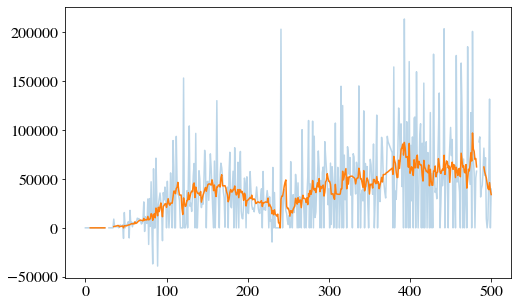

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(df_br['Days Since First Death'], df_br['RecoveredChange'], alpha=0.3)
ax.plot(df_br['Days Since First Death'], df_br['RecoveredChange_MA'])